In [1]:
import os
import tensorflow as tf
print(tf.__version__)

C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\ten

1.10.0


In [2]:
from agents.NeuralNetwork import NeuralNetwork
import random as pyrand
import tensorflow as tf
from agents.AbstractAgent import AbstractAgent
from resources.SafetyChecks import verifyBatchShape
import numpy as np
from environment.Config import ConfigTimeSeries
from environment.BaseEnvironment import TimeSeriesEnvironment
from resources import Utils as utils

In [3]:
from resources.Plots import plot_actions



class BinaryStateEnvironment:
    """
    The class environment is a wrapper around the TimeSeriesEnvironment. We are changing the interface of the environment by
    overriding the methods to use for RL-Computations.
    """

    def __init__(self, environment: TimeSeriesEnvironment):
        """
        Initializing the BinaryStateEnv by wrapping the BaseEnvironment
        :param environment: TimeSeriesEnvironment
        """
        self.env = None
        if environment is None:
            raise TypeError("Base environment must be instantiated")
        elif isinstance(environment, TimeSeriesEnvironment):
            self.env = environment
        else:
            raise TypeError("Input is not of type TimeSeriesEnvironment")

    def __state(self, action):
        """
        :param timeseries:
        :param cursor: the position where in the TimeSeries we are currently
        :return: The Value of the current position, states with the same value are treated the same way
        """
        state = np.asarray(
            [np.float64(self.env.timeseries_labeled['value'][self.env.timeseries_cursor]),
             self.env.timeseries_labeled["anomaly"][self.env.timeseries_cursor]])
        return state

    def __reward(self, action):
        """
        :param action: The reward depends on the action we are taking in the environment
        :return: action-reward value
        """
        state = self.__state(action)
        if state[1] == 1:
            if action == 1:
                return 1
            if action == 0:
                return -1
        if state[1] == 0:
            if action == 1:
                return -1
            if action == 0:
                return 1
        return 0

    def reset(self):
        """
        Reset the current Series to the first Value.
        :return: initial state
        """
        self.env.timeseries_cursor = self.env.timeseries_cursor_init
        self.env.normalize_timeseries()
        self.env.done = False
        init_state = self.__state(0)
        return init_state

    def step(self, action):
        """
        Taking a step inside the current Series.
        :param action: a valid action value
        :return: (S,A,R,S',Done)
        """
        current_state = self.__state(action)
        reward = self.__reward(action)
        self.env.update_cursor()
        next_state = self.__state(action)
        return current_state, action, reward, next_state, self.env.is_done(self.env.timeseries_cursor)

    def __len__(self):
        """
        Length of the current Timeseries
        :return: int
        """
        return len(self.env)

    def __getattr__(self, item):
        """
        Get the attribute of the base environment
        :param item: String of field key
        :return: attribute item of the base environment
        """
        return getattr(self.env, item)

In [4]:
import os
import random
import time
from collections import deque
from resources.Utils import load_object, store_object
from random import shuffle


class MemoryBuffer:
    def __init__(self, max, id, init_size=50000):
        self.memory = deque([], maxlen=max)
        self.id = "memory_{}.obj".format(id)
        self.init_size = init_size

    def store(self, state, action, reward, nstate, done):
        # Store the experience in memory if full popleft and append right
        if len(self.memory) < self.memory.maxlen:
            self.memory.append((state, action, reward, nstate, done))
        else:
            self.memory.popleft()
            self.memory.append((state, action, reward, nstate, done))

    def init_memory(self, env):
        # time measurement for memory initialization
        init_time = time.time()
        # resetting environment once
        env.reset()
        # try to load memory from local file
        if not os.path.isfile(self.id):
            self.memory = load_object(self.id)
        # try to init memory by taking random steps in our environment until the deque is full
        else:
            while True:
                # break if memory is full
                if len(self.memory) >= self.init_size:
                    break
                # check if we need to reset env and still fill our memory
                if env.is_done(env.timeseries_cursor):
                    env.reset()
                # get random action
                action = random.randrange(env.action_space_n)
                # take step in env and append
                state, action, reward, nstate, done = env.step(action)
                # store our memory in class
                self.store(state, action, reward, nstate, done)
            # store our memory locally to reduce loading time on next run
            store_object(self.memory, self.id)
            print("Memory is initialized, {} Samples stored. It took {} seconds".format(len(self.memory),
                                                                                        time.time() - init_time))

    def get_exp(self, batch_size):
        # Popping from the Memory Queue which should be filled randomly beforehand
        shuffle(self.memory)
        samples = [self.memory.popleft() for _i in range(batch_size)]
        for sample in samples:
            self.memory.append(sample)
        return samples

    def __len__(self):
        return len(self.memory)

In [5]:
class Simulator:
    """
    This class is used to train and to test the agent in its environment
    """

    def __init__(self, max_episodes, agent, environment, update_steps):
        """
        Initialize the Simulator with parameters

        :param max_episodes: How many episodes we want to learn, the last episode is used for evaluation
        :param agent: the agent which should be trained
        :param environment: the environment to evaluate and train in
        :param update_steps: the update steps for the Target Q-Network of the Agent
        """
        self.max_episodes = max_episodes
        self.episode = 0
        self.agent = agent
        self.env = environment
        self.update_steps = update_steps

        # information variables
        self.training_scores = []
        self.test_rewards = []
        self.test_actions = []

    def run(self):
        """
        This method is for scheduling training before testing
        :return: True if finished
        """
        while True:
            start = utils.start_timer()
            start_testing = self.__can_test()
            if not start_testing:
                info = self.__training_iteration()
                print("Training episode {} took {} seconds {}".format(self.episode, utils.get_duration(start), info))
                self.__next__()
            if start_testing:
                self.__testing_iteration()
                print("Testing episode {} took {} seconds".format(self.episode, utils.get_duration(start)))
                break
            self.agent.anneal_epsilon()
        plot_actions(self.test_actions[0], getattr(self.env, "timeseries_labeled"))
        return True

    def __training_iteration(self):
        """
        One training iteration is through the complete timeseries, maybe this needs to be changed for
        bigger timeseries datasets.

        :return: Information of the training episode, if update episode or normal episode
        """
        rewards = 0
        state = self.env.reset()
        for idx in range(len(
                self.env)):
            action = self.agent.action(state)
            state, action, reward, nstate, done = self.env.step(action)
            # print("TRAIN {}: {} {} {} {}".format(idx, state, action, reward, nstate))
            rewards += reward
            self.agent.memory.store(state, action, reward, nstate, done)
            state = nstate
            if done:
                self.training_scores.append(rewards)
                break
        depth = 0
        while True:
            if depth < 5:
                self.agent.experience_replay()
                depth += 1
            else:
                break

        # Target Model Update
        if self.episode % self.update_steps == 0:
            self.agent.update_target_model()
            return "Update Target Model"
        return ""

    def __testing_iteration(self):
        """
        The testing iteration with greedy actions only.
        """
        rewards = 0
        actions = []
        state = self.env.reset()
        self.agent.epsilon = 0
        for idx in range(len(
                self.env)):
            action = self.agent.action(state)
            actions.append(action)
            state, action, reward, nstate, done = self.env.step(action)
            # print("TEST {}: {} {} {} {}".format(idx, state, action, reward, nstate))
            rewards += reward
            state = nstate
            if done:
                actions.append(action)
                self.test_rewards.append(rewards)
                self.test_actions.append(actions)
                break

    def __can_test(self):
        """
        :return: True if last episode, False before
        """
        if self.episode >= self.max_episodes:
            return True
        return False

    def __next__(self):
        # increment episode counter
        self.episode += 1

In [6]:
from environment.BaseEnvironment import TimeSeriesEnvironment


class BinaryStateAgent(AbstractAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.callbacks = tf.keras.callbacks.TensorBoard(log_dir="../Logs")

    def action(self, state):
        """
        The action function chooses according to epsilon-greedy policy actions in our environment
        :param state: The state, representing the Sliding Window of datapoints in our Timeseries
        :return: returns an action in our action space ∈ (0, 1)
        """
        if np.random.rand() <= self.epsilon:
            return pyrand.randrange(self.action_space)  # Explore Actions by percentage epsilon
        if self.epsilon == 0:  # greedy action choice for testing the agents performance in our environment
            action_values = self.target_dqn.predict(np.array(state).reshape(1, 2))
        else:
            action_values = self.dqn.predict(np.array(state).reshape(1, 2))
        # print("AV at S: {}, {}, AMAX: {}".format(state, action_values, np.argmax(action_values)))
        return np.argmax(action_values)

    def experience_replay(self):
        """
        Experience Replay is necessary for our off-policy algorithm to derive the optimal policy out of the
        Transition-Set:(state, action, reward, next_state, done) which is of size: batch_size.
        DQN: The algorithm estimates the return (total discounted future reward) for state-action pairs assuming a greedy
        policy was followed despite the fact that it's not following a greedy policy.

        :param batch_size: number of transitions to be fitted at once
        """
        # get a sample from the memory buffer
        minibatch = self.memory.get_exp(self.batch_size)

        # create default input arrays for the fitting of the model
        x = []
        y = []

        state_predict, nextstate_predict, nextstate_predict_target = self.predict_on_batch(minibatch)

        index = 0
        # we must iterate through the batch and calculate all target values for the models q values
        for state, action, reward, nextstate, done in minibatch:
            x.append(state)
            # Predict from state
            nextstate_action_predict_target = nextstate_predict_target[index]
            nextstate_action_predict_model = nextstate_predict[index]
            # now we calculate the target Q-Values for our input batch of transitions
            if done:  # Terminal State: Just assign reward
                target = reward
            else:  # Non terminal State: Update the Q-Values
                target = reward + self.gamma * nextstate_action_predict_target[
                    np.argmax(nextstate_action_predict_model)]  # Using Q-Value from our Target Network follows DDQN
            target_f = state_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        # Reshape for Keras Fitting Function
        x_reshape = np.array(x)
        y_reshape = np.array(y)
        self.hist = self.dqn.fit(x_reshape, y_reshape, epochs=self.fit_epoch, verbose=0)

    def predict_on_batch(self, batch):
        """
        Helper method to get the predictions on out batch of transitions in a shape that we need
        :param batch: n batch size
        :return: NN predictions(state), NN predictions(next_state), Target NN predictions(next_state)
        """
        # Convert to numpy for speed by vectorization
        st = np.array(list(list(zip(*batch))[0]))
        nst = np.array(list(list(zip(*batch))[3]))

        # safety check if every input consists of a binary feature
        verifyBatchShape(st, np.zeros((self.batch_size, 2)).shape)

        # predict on the batches with the model as well as the target values
        st_predict = self.dqn.predict(st)
        nst_predict = self.dqn.predict(nst)
        nst_predict_target = self.target_dqn.predict(nst)

        return st_predict, nst_predict, nst_predict_target

Successfully stored to memory_binary_agent.obj
Memory is initialized, 50000 Samples stored. It took 3.934513568878174 seconds
Training episode 0 took 1.2675743103027344 seconds Update Target Model
Training episode 1 took 0.7998614311218262 seconds 
Training episode 2 took 0.9005956649780273 seconds 
Training episode 3 took 0.9883551597595215 seconds 
Training episode 4 took 0.9823737144470215 seconds 
Training episode 5 took 1.040222406387329 seconds Update Target Model
Training episode 6 took 1.1190056800842285 seconds 
Training episode 7 took 1.1409499645233154 seconds 
Training episode 8 took 1.1968004703521729 seconds 
Training episode 9 took 1.2596325874328613 seconds 
Training episode 10 took 1.2855865955352783 seconds Update Target Model
Testing episode 11 took 0.4318253993988037 seconds
Successfully stored to memory_binary_agent.obj
Memory is initialized, 50000 Samples stored. It took 3.9753763675689697 seconds
Training episode 0 took 0.702120304107666 seconds Update Target Mod

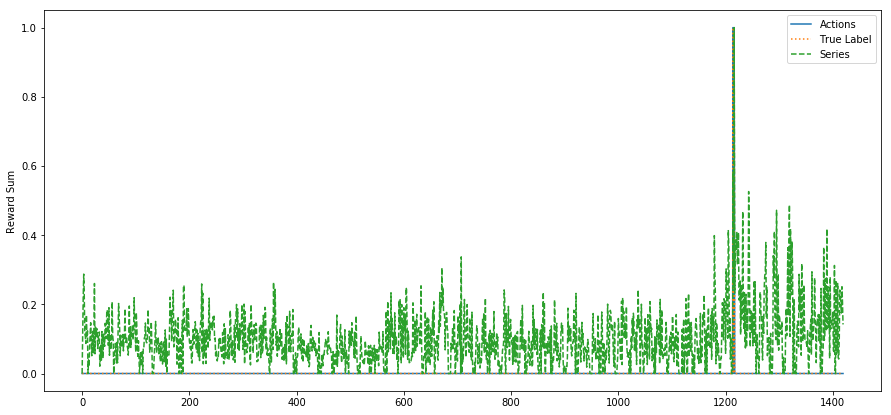

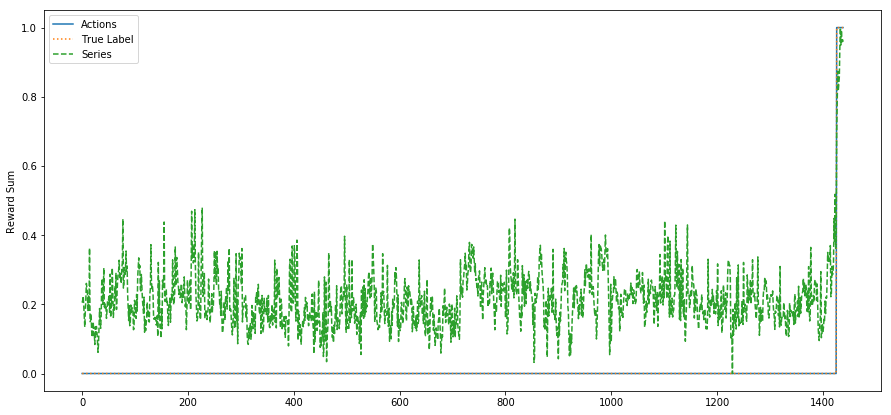

C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


KeyboardInterrupt: 

In [7]:
#tf.compat.v1.disable_eager_execution()
dqn = NeuralNetwork(input_dim=2,
                    input_neurons=3,hidden_neurons=128).keras_model
for subdir, dirs, files in os.walk("../ts_data/A1Benchmark"):
    for file in files:
        if file.find('.csv') != -1:
            agent = BinaryStateAgent(dqn=dqn, memory=MemoryBuffer(max=500000, id="binary_agent"), alpha=0.0001, gamma=0.99, \
                         epsilon=1.0, epsilon_end=0.0, epsilon_decay=0.9, fit_epoch=2, action_space=2, \
                         batch_size=256)
            config = ConfigTimeSeries(seperator=",", window=1)
            env = BinaryStateEnvironment(
                TimeSeriesEnvironment(verbose=False, filename="./A1Benchmark/{}".format(file), config=config, window=True))
            simulation = Simulator(11, agent, env,5)
            agent.memory = MemoryBuffer(max=500000, id="binary_agent")
            agent.memory.init_memory(env=env)
            simulation.run()